[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-27 15:21:36,814] Making new env: ppaquette/DoomBasic-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = 7
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

96.0 True


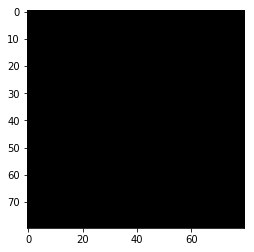

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 15:21:37,678] Making new env: ppaquette/DoomBasic-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

KeyError: 5

In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

KeyError: 5

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [ ]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [ ]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [ ]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [ ]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [ ]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [ ]:
import os
tmp = GAME_NAME.split('/')[1]
os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

In [ ]:
save(qvalues_layer,"dist_weights/{}".format(tmp))

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets